# Load Data

In [1]:
# %pip install tensorflow
# %pip install distutils
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils
Note: you may need to restart the kernel to use updated packages.


### Data Prep

In [25]:
# Subset your data the same 3 digit classes you used in the Random Forest problem from the last assignment.

# Again, You can totally copy any code over from the fmnist_examples notebook and modify it.
# You can use chatGPT, copilot, google, or other AI or online resources.
# Use each other, the goal is to complete the objectives and maybe learn something new, not to struggle to make up code on your own.
# We have prior notebooks, chatGPT, the internet, and each other for the rapids projects, so use them here if they will help!

# Extract the 3 classes from the training data

train_filter = (y_train == 1) | (y_train == 7) | (y_train == 9)
x_train_179 = x_train[train_filter]
y_train_179 = y_train[train_filter]

# Extract the 3 classes from the test data

test_filter = (y_test == 1) | (y_test == 7) | (y_test == 9)
x_test_179 = x_test[test_filter]
y_test_179 = y_test[test_filter]

print(y_train_179)
y_train_79_bin = (y_train_179 == 7).astype(int) | (y_train_179 == 9).astype(int)
y_train_9_bin = (y_train_179 == 9).astype(int)
y_train_179_bin = y_train_79_bin + y_train_9_bin
y_test_79_bin = (y_test_179 == 9).astype(int) | (y_test_179 == 7).astype(int)
y_test_9_bin = (y_test_179 == 9).astype(int)
y_test_179_bin = y_test_79_bin + y_test_9_bin
print(y_train_179_bin)


[1 9 1 ... 9 9 1]
[0 2 0 ... 2 2 0]
[7 1 1 ... 7 9 1]
[1 0 0 ... 1 2 0]


### Plot Data

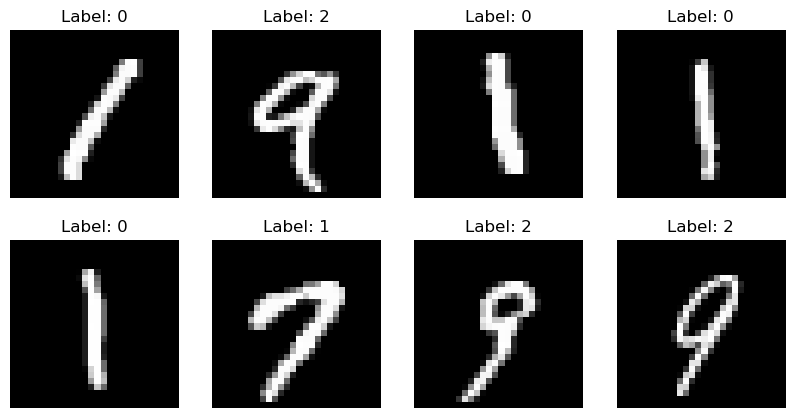

In [27]:
## Plot 6 to 10 images from your data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train_179[i], cmap='gray')
    plt.title(f'Label: {y_train_179_bin[i]}')
    plt.axis('off')

plt.show()


# CNN with Pytorth

### Design the CNN Model

In [6]:
# Define a CNN model. 
# You are welcome to use the model from the fmnist_examples notebook, or you can try to create a better one.
# Either way, I recommend starting with the model from the fmnist_examples notebook and modifying it as you like.

# Important: Remember that our output has 3 classes, not 2 like in the Fashion MNIST dataset,
# So you will have to change at least one thing in the model to accommodate this.

import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### Data Prep

In [28]:
# Convert your data to PyTorch tensors and create DataLoader objects for training and testing

x_train_tensor = torch.tensor(x_train_179.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_179_bin, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_179.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_179_bin, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Fit the CNN

In [29]:
# Initialize the model, loss function, and optimizer
t_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = t_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_outputs = t_model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# How does the test accuracy compare to that of the Random Forest model previously used?


Epoch 1/10, Train Loss: 0.1150, Validation Loss: 0.0271, Validation Accuracy: 0.9896
Epoch 2/10, Train Loss: 0.0258, Validation Loss: 0.0189, Validation Accuracy: 0.9943
Epoch 3/10, Train Loss: 0.0180, Validation Loss: 0.0143, Validation Accuracy: 0.9940
Epoch 4/10, Train Loss: 0.0126, Validation Loss: 0.0091, Validation Accuracy: 0.9972
Epoch 5/10, Train Loss: 0.0112, Validation Loss: 0.0078, Validation Accuracy: 0.9965
Epoch 6/10, Train Loss: 0.0086, Validation Loss: 0.0126, Validation Accuracy: 0.9962
Epoch 7/10, Train Loss: 0.0064, Validation Loss: 0.0087, Validation Accuracy: 0.9959
Epoch 8/10, Train Loss: 0.0040, Validation Loss: 0.0111, Validation Accuracy: 0.9959
Epoch 9/10, Train Loss: 0.0043, Validation Loss: 0.0078, Validation Accuracy: 0.9965
Epoch 10/10, Train Loss: 0.0046, Validation Loss: 0.0106, Validation Accuracy: 0.9956


### Plot Confusion Matrix

[[1135    0    0]
 [   4 1023    1]
 [   5    4 1000]]


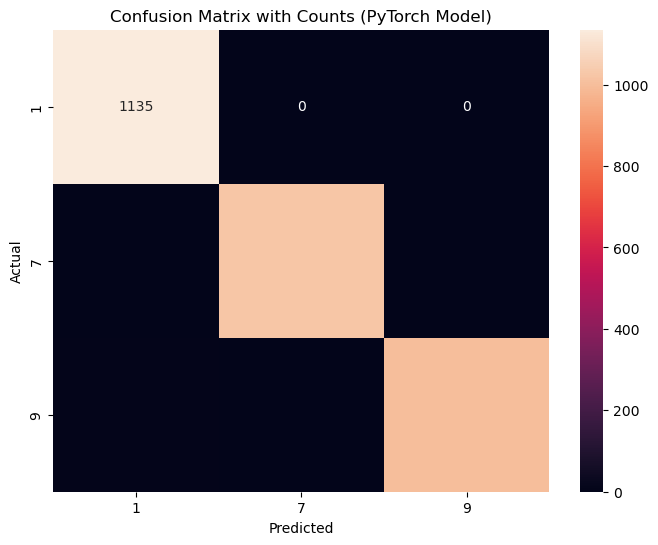

In [30]:
# Compute and plot a confusion matrix.

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
t_model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = t_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions)

# Compute the confusion matrix
conf_matrix_torch = confusion_matrix(y_test_179_bin, test_predictions)

# Print the confusion matrix
print(conf_matrix_torch)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_torch, annot=True, fmt='d', xticklabels=[1, 7, 9], yticklabels=[1, 7, 9])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts (PyTorch Model)')
plt.show()

# Where are misclassifications occurring?
# How does your test accuracy compare to that of the Random Forest model previously made?

### Plot Misclassifications

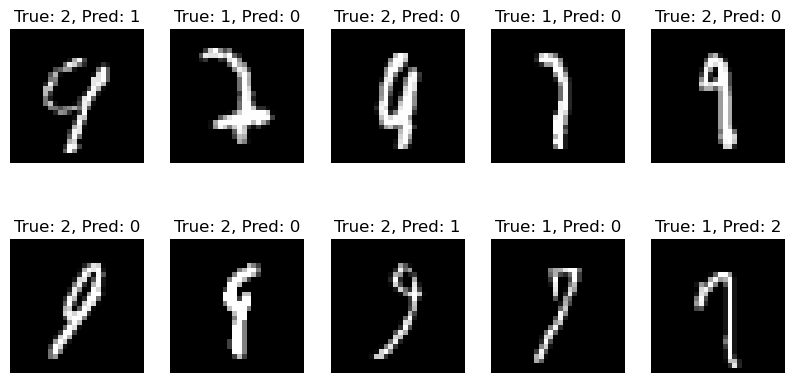

In [32]:
# Plot some of the misclassifications.

misclassified_indices_torch = [i for i in range(len(y_test_179_bin)) if test_predictions[i] != y_test_179_bin[i]]

plt.figure(figsize=(10, 5))

for i, idx in enumerate(misclassified_indices_torch[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_179[idx], cmap='gray')
    plt.title(f'True: {y_test_179_bin[idx]}, Pred: {test_predictions[idx]}')
    plt.axis('off')

plt.show()

# Can you see why the model made the misclassifications it did?

# CNN with Transformations

### Data Transformations

In [4]:
# Implement some kind of Appropriate Data Transformation(s) for this data set.
# You can/should copy the train_mod function from the fmnist_examples_ml2 notebook, but you will have to 
# think about whether all of the transformations are appropriate for this data set and maybe adjust them.

# There is 1 specific modification you must make to the train_mod function! Other modifications are great, but optional.
# %pip install torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Define data augmentation transformations
train_mod = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))    # Normalize to [-1, 1]
])

test_mod = transforms.Compose([
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))       # Normalize to [-1, 1]
])

# Load the MNIST train dataset
train_dataset = MNIST(root="./data", train=True, transform=train_mod, download=True)

# Filter the dataset to only include the 3 classes of interest
train_indices = (train_dataset.targets == 1) | (train_dataset.targets == 7) | (train_dataset.targets == 9)
train_dataset.targets = train_dataset.targets[train_indices]
train_dataset.data = train_dataset.data[train_indices]

# Convert to labels to 0, 1, 2
for i in train_dataset.targets:
    if train_dataset.targets[i] == 1:
        train_dataset.targets[i] = 0
    if train_dataset.targets[i] == 7:
        train_dataset.targets[i] = 1
    if train_dataset.targets[i] == 9:
        train_dataset.targets[i] = 2

# Convert the dataset to a DataLoader object
train_loader_mod = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Repeat for the loading, filtering, and conversions on the test dataset
test_dataset = MNIST(root="./data", train=False, transform=test_mod, download=True)

test_indices = (test_dataset.targets == 1) | (test_dataset.targets == 7) | (test_dataset.targets == 9)
test_dataset.targets = test_dataset.targets[test_indices]
test_dataset.data = test_dataset.data[test_indices]

for i in test_dataset.targets:
    if test_dataset.targets[i] == 1:
        test_dataset.targets[i] = 0
    if test_dataset.targets[i] == 7:
        test_dataset.targets[i] = 1
    if test_dataset.targets[i] == 9:
        test_dataset.targets[i] = 2

test_loader_mod = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot some of the images in your train_loader. Check that your transformations provide
# a reasonable augmentation of the data. If they don't, adjust them in the train_mod function.

# Iterate over batches
for images, labels in train_loader_mod:
    # images now contain dynamically augmented data
    print(images.shape, labels.shape)
    break  # Checking one batch

# Plot some of the transformed images
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.show()

ConnectionResetError: [Errno 54] Connection reset by peer

### Fit the CNN

In [7]:
# Run your CNN using the data loaders containing different transformations.
# This very well may not be better than the model trained on the original data, 
# since we don't expect our test data to be transformed. But try it out.

# Provide initializations for a new model and train the model.
# Report some notion of accuracy, loss or both as it builds to see how well your model is doing.

# Initialize the model, loss function, and optimizer
t_model3 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model3.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model3.train()
    running_loss = 0.0
    for inputs, labels in train_loader_mod:
        optimizer.zero_grad()
        outputs = t_model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader_mod:
            val_outputs = t_model3(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader_mod)
    avg_val_loss = val_loss / len(test_loader_mod)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# How does the test accuracy compare to other models you've built?

NameError: name 'train_loader_mod' is not defined